# VeloVAE using the gastrulation erythroid generation data. 
RNA velocity of the transcriptional boost genes are investigated. We use the same data used by cellDancer. In the following, we check VeloVAE's performance using all selected genes (2000) or only the MURK genes (61).

In [1]:
import anndata
import numpy as np
import scvelo as scv
import scanpy as sc
import sys
import torch
import os.path
sys.path.append('../')
import velovae as vv
import celldancer as cd

In [2]:
dataset = "Gastrulation"
adata = scv.read("data/Gastrulation/GastrulationErythroid.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 12329 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
# murk genes
import pandas as pd
murk_genes=pd.read_csv('data/Gastrulation/13059_2021_2414_MOESM3_ESM.csv')['index']
adata_murk=adata[:,adata.var_names.isin(murk_genes)]

In [5]:
adata_murk

View of AnnData object with n_obs × n_vars = 12329 × 61
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

Pick some genes to plot.

In [6]:
gene_plot = ["Hba-x", "Smim1"]

<br><br><br><br><br>
# PART 1. Use all genes. 
dataset -> adata

In [7]:
model_path_base = f"checkpoints/{dataset}"
figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

saving figure to file figures/Gastrulation/umap.png


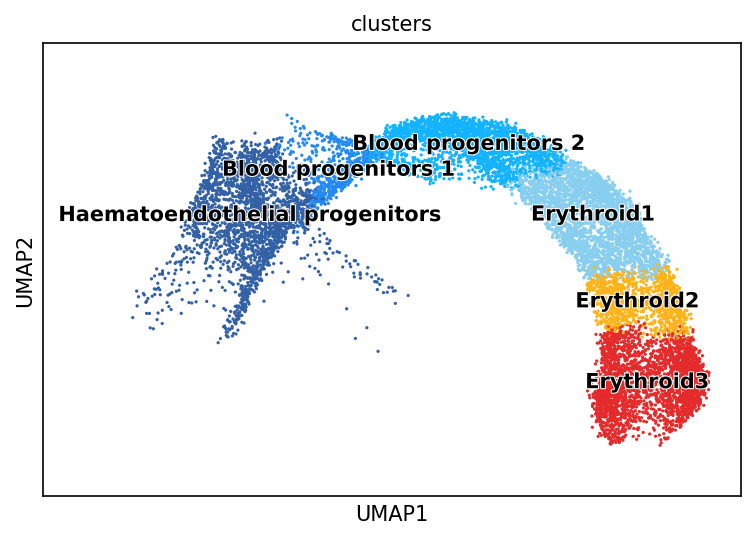

In [8]:
os.makedirs(figure_path_base, exist_ok=True)
scv.pl.scatter(adata_murk, basis='umap', frameon=True, save=figure_path_base+"/umap.png", ylim=[3,18], dpi=150, palette=cd.cdplt.colormap.colormap_erythroid)


## Train a VeloVAE Basic Model
The basic model assumes fixed transcription rates. This serves as a baseline for our method.
***

In [9]:
figure_path = figure_path_base+"/VanillaVAE"
model_path = model_path_base+"/VanillaVAE"
data_path = data_path_base

In [10]:
torch.manual_seed(2022)
np.random.seed(2022)

vanilla_vae = vv.VanillaVAE(adata, tmax=20, device='cpu')
vanilla_vae.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path)
vanilla_vae.save_model(model_path, "encoder_vanilla","decoder_vanilla")
vanilla_vae.save_anndata(adata, 'vanilla', data_path, file_name=f"{dataset}_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
------------------------- Train a Vanilla VAE -------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -1924.051, Test ELBO = -3719.635, 	 Total Time =   0 h :  0 m :  9 s
Epoch 100: Train ELBO = 1772.255, Test ELBO = 1770.175, 	 Total Time =   0 h :  8 m : 25 s
********* Early Stop Triggered at epoch 170. *********
*********              Finished. Total Time =   0 h : 14 m : 13 s             *********



## Train a VeloVAE Model
Full model. In addition to the blocks in the basic model, there is a decoder network producing variable transcription rates.
***

In [11]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base

In [12]:
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata, tmax=20, dim_z=5, device='cpu')
vae.train(adata, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="umap")
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata, 'vae', data_path, file_name=f"{dataset}_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -1630.727, Test ELBO = -533225.438, 	 Total Time =   0 h :  0 m : 10 s
Epoch 100: Train ELBO = 1930.291, Test ELBO = 1916.679, 	 Total Time =   0 h :  9 m : 50 s
Epoch 200: Train ELBO = 2024.709, Test ELBO = 2028.547, 	 Total Time =   0 h : 19 m : 28 s
*********       Stage 1: Early Stop Triggered at epoch 290.       *********
*******

## Train a VeloVAE (Full VB) Model
The full VB model is a slight extension of VeloVAE by treating the rate parameters as random variables. 
***

In [13]:
figure_path = figure_path_base+"/FullVB"
model_path = model_path_base+"/FullVB"
data_path = data_path_base

In [14]:
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata, tmax=20, dim_z=5, device='cpu')
full_vb.train(adata, plot=True, gene_plot=gene_plot, figure_path=figure_path, embed="umap")
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata, 'fullvb', data_path, file_name=f"{dataset}_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -1676.432, Test ELBO = -533287.500, 	 Total Time =   0 h :  0 m : 10 s
Epoch 100: Train ELBO = 1907.938, Test ELBO = 1885.032, 	 Total Time =   0 h : 10 m :  1 s
Epoch 200: Train ELBO = 2021.241, Test ELBO = 2003.861, 	 Total Time =   0 h : 19 m : 57 s
*********       Stage 1: Early Stop Triggered at epoch 247.       *********
*******

## Train a Branching ODE Model
The branching ODE treats each cell type separately and learns type-specific rate parameters. 
***

In [15]:
figure_path = figure_path_base+"/BrODE"
model_path = model_path_base+"/BrODE"
data_path = data_path_base

In [16]:
torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata, "clusters", "fullvb_time", "fullvb_z", graph_param={"dt":(0.01,0.05), "k":5, "n_par":2})
brode.train(adata, "fullvb_time", "clusters", plot=True, gene_plot=gene_plot, figure_path=figure_path)
brode.save_model(model_path, "brode")
brode.save_anndata(adata, 'brode', data_path, file_name=f"{dataset}_out.h5ad")

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.
------------------------ Train a Branching ODE ------------------------
                                Blood progenitors 1  Blood progenitors 2  Erythroid1  Erythroid2  Erythroid3  Haematoendothelial progenitors
Blood progenitors 1                             0.0                  1.0         0.0         0.0         0.0                             0.0
Blood progenitors 2                             0.0                  0.0         1.0         0.0         0.0                             0.0
Erythroid1                                      0.0                  0.0         0.0         1.0         0.0                             0.0
Erythroid2                                      0.0                  0.0         0.0         0.0         1.0                             0.0
Erythroid3                                      

## Velocity stream plot and gene velocity phase plot

### (i) Trained with all genes, all genes are used to compute the cell velocity






Model vae using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:03:28) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


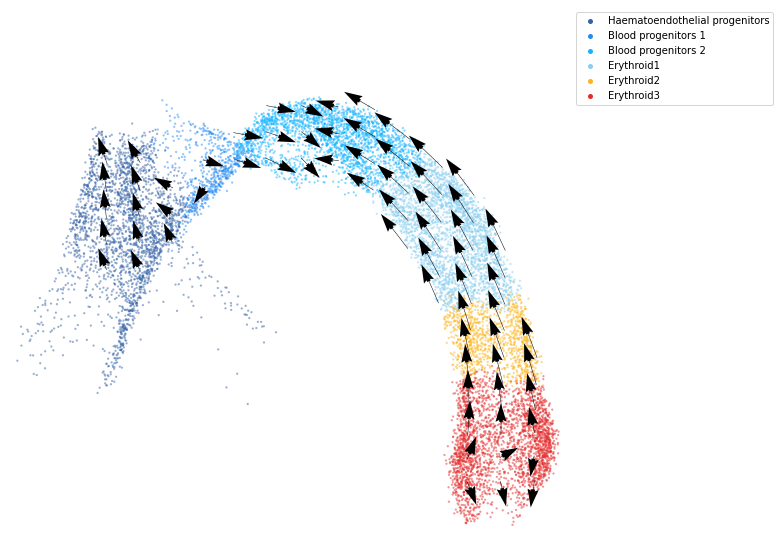

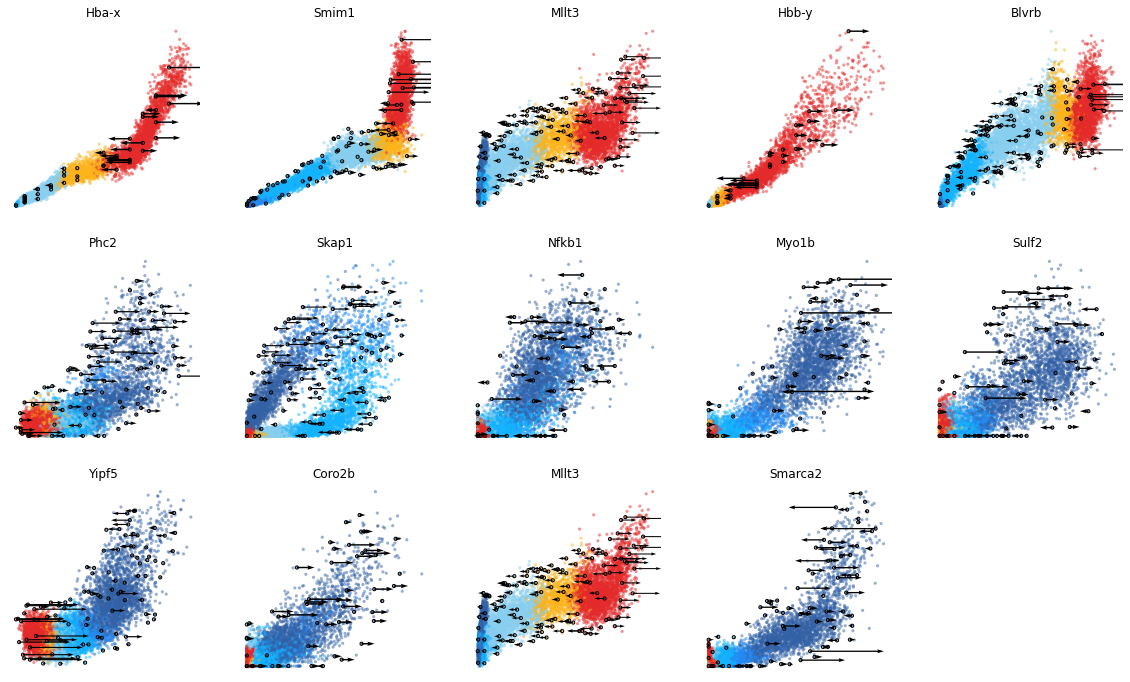






Model fullvb using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:03:51) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)


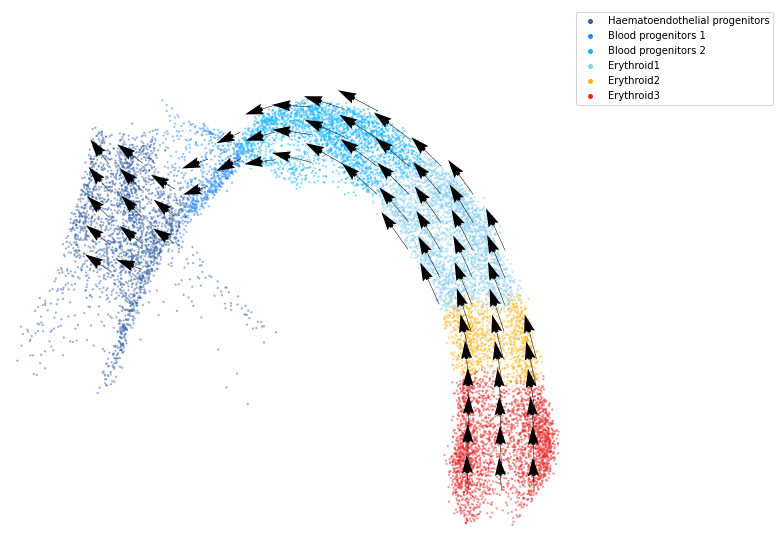

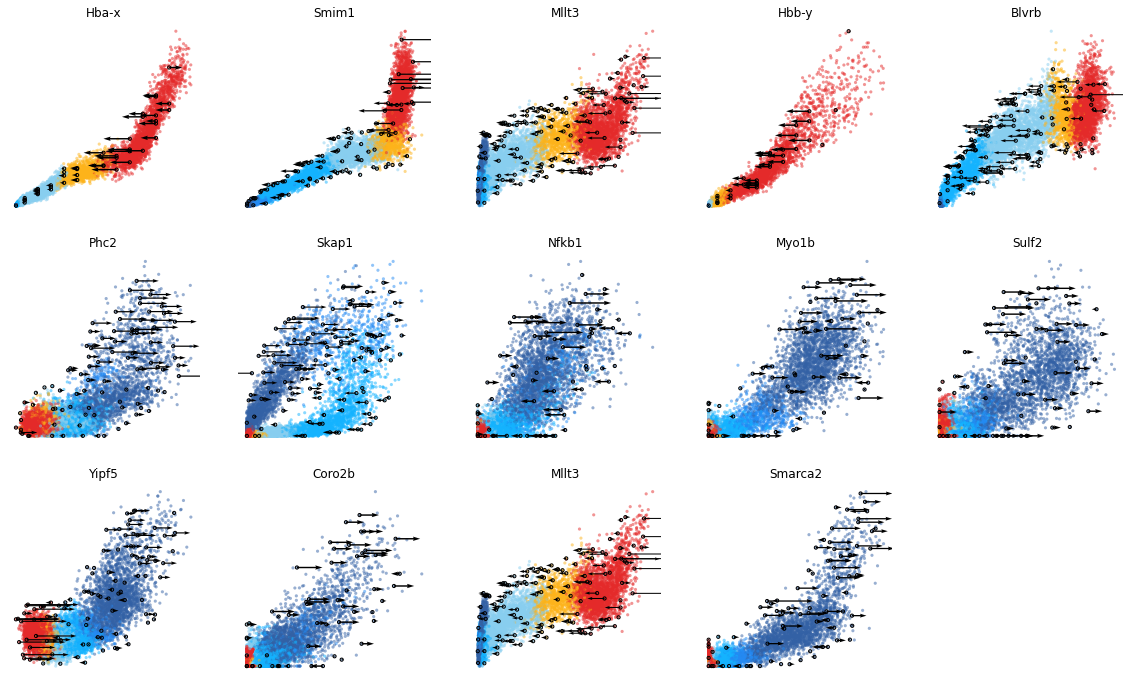






Model brode using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:03:35) --> added 
    'brode_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:05) --> added
    'brode_velocity_umap', embedded velocity vectors (adata.obsm)


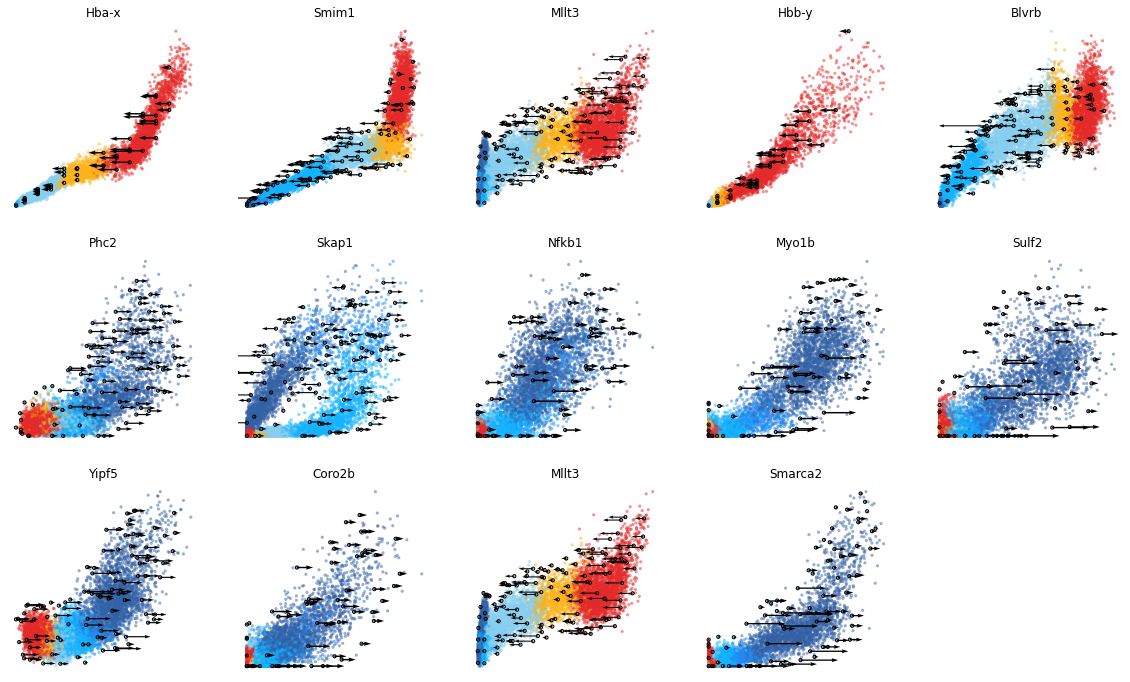

In [17]:
import matplotlib.pylab as plt
import math
from adata_to_df import adata_to_df

figure_path_base = f"figures/{dataset}"
data_path_base = f"data/{dataset}"

adata.var['velocity_genes']=True
basis = "umap"
gene_list = ['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2','Yipf5','Coro2b','Mllt3','Smarca2']

for key in ['vae', 'fullvb', 'brode']:
    print("\n\n\n\n")
    print(f"Model {key} using all genes:")
    ## Convert ADATA to Dataframe. 
    # Note VeloVADE does not have the feature to calculate du/dt, we set it to 0.
    scv.tl.velocity_graph(adata, vkey=f'{key}_velocity', n_jobs=12)
    scv.tl.velocity_embedding(adata, vkey=f'{key}_velocity', basis=basis)
    adata.write_h5ad(data_path_base+f"/{dataset}_out.h5ad")

    df = adata_to_df(adata, \
        us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_velocity_u', f'{key}_velocity'], \
        cell_type_para='clusters', embed_para=f'X_{basis}', \
        embed_pred_para=f'{key}_velocity_{basis}')

    # plot cell velocity
    fig, ax = plt.subplots(figsize=(10,10))
    cd.cdplt.scatter_cell(ax,
                    df,
                    colors=cd.cdplt.colormap.colormap_erythroid,
                    alpha=0.5,
                    s=5,
                    velocity=True,
                    legend='on',
                    min_mass=200,
                    arrow_grid=(20,40),
                    custom_ylim=[4,18],
                    custom_xlim=[-5,11])

    ax.axis('off')
    plt.savefig(figure_path_base+f"/cell_velocity_all_genes_{key}_{basis}.pdf")
    plt.show()

    ncols=5
    height=math.ceil(len(gene_list)/5)*4
    fig = plt.figure(figsize=(20, height))

    for i in range(len(gene_list)):
        ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
        cd.cdplt.scatter_gene(
            ax=ax,
            x='splice',
            y='unsplice',
            cellDancer_df=df,
            custom_xlim=None,
            custom_ylim=None,
            colors=cd.cdplt.colormap.colormap_erythroid,
            alpha=0.5,
            s = 10,
            velocity=True,
            gene=gene_list[i])

        ax.set_title(gene_list[i])
        ax.axis('off')
    plt.savefig(figure_path_base+f"/gene_velocity_all_genes_{key}.pdf")
    plt.show()

### (ii) Trained with all genes, but cell velocity is only computed using the MURK genes






Model vae using all genes:
computing velocities
    finished (0:00:00) --> added 
    'vae_murk_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:48) --> added 
    'vae_murk_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'vae_murk_velocity_umap', embedded velocity vectors (adata.obsm)


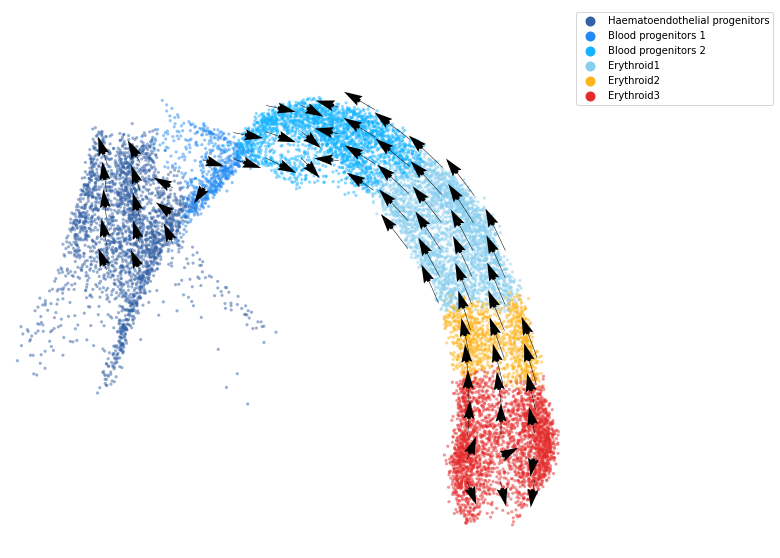






Model fullvb using all genes:
computing velocities
    finished (0:00:00) --> added 
    'fullvb_murk_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:55) --> added 
    'fullvb_murk_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'fullvb_murk_velocity_umap', embedded velocity vectors (adata.obsm)


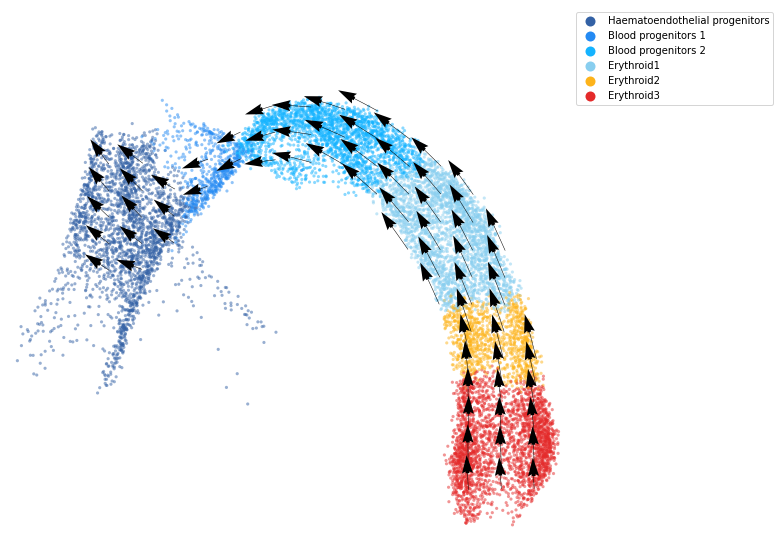






Model brode using all genes:
computing velocities
    finished (0:00:00) --> added 
    'brode_murk_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:45) --> added 
    'brode_murk_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'brode_murk_velocity_umap', embedded velocity vectors (adata.obsm)


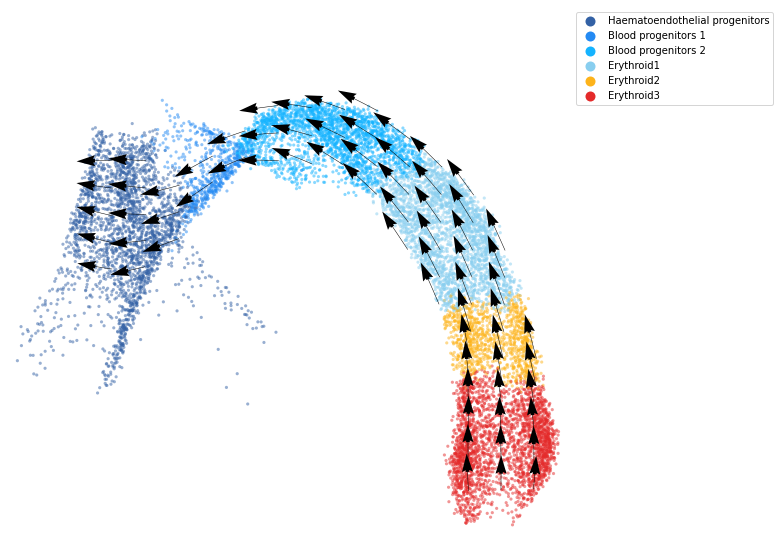

In [18]:
adata_compute_cell_velocity_only_murk=adata[:,adata.var_names.isin(murk_genes)]
adata_compute_cell_velocity_only_murk.var['velocity_genes']=True
basis = "umap"
gene_list = ['Hba-x','Smim1','Mllt3','Hbb-y','Blvrb','Phc2','Skap1','Nfkb1','Myo1b','Sulf2','Yipf5','Coro2b','Mllt3','Smarca2']

for key in ['vae', 'fullvb', 'brode']:
    print("\n\n\n\n")
    print(f"Model {key} using all genes:")
    ## Convert ADATA to Dataframe. 
    # Note VeloVADE does not have the feature to calculate du/dt, we set it to 0.
    scv.tl.velocity_graph(adata_compute_cell_velocity_only_murk, vkey=f'{key}_murk_velocity', n_jobs=12)
    scv.tl.velocity_embedding(adata_compute_cell_velocity_only_murk, vkey=f'{key}_murk_velocity', basis=basis)
    adata_compute_cell_velocity_only_murk.write_h5ad(data_path_base+f"/{dataset}_murk_out.h5ad")

    df = adata_to_df(adata_compute_cell_velocity_only_murk, \
        us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_murk_velocity_u', f'{key}_murk_velocity'], \
        cell_type_para='clusters', embed_para=f'X_{basis}', \
        embed_pred_para=f'{key}_velocity_{basis}')

    # plot cell velocity
    fig, ax = plt.subplots(figsize=(10,10))
    cd.cdplt.scatter_cell(ax,
                    df,
                    colors=cd.cdplt.colormap.colormap_erythroid,
                    alpha=0.5,
                    s=10,
                    velocity=True,
                    legend='on',
                    min_mass=200,
                    arrow_grid=(20,40),
                    custom_xlim=[-5,11],
                    custom_ylim=[4,18])

    ax.axis('off')
    plt.savefig(figure_path_base+f"/gene_velocity_murk_genes_{key}.pdf")
    plt.show()

<br><br><br><br><br>
# PART 2. Use only MURK Genes.
dataset -> adata_murk

In [19]:
model_path_base = f"checkpoints/{dataset}_murk"
figure_path_base = f"figures/{dataset}_murk"
data_path_base = f"data/{dataset}_murk"


## Train a VeloVAE Basic Model
***

In [20]:
figure_path = figure_path_base+"/VanillaVAE"
model_path = model_path_base+"/VanillaVAE"
data_path = data_path_base
torch.manual_seed(2022)
np.random.seed(2022)

vanilla_vae = vv.VanillaVAE(adata_murk, tmax=20, device='cpu')
vanilla_vae.train(adata_murk, plot=True, gene_plot=gene_plot, figure_path=figure_path)
vanilla_vae.save_model(model_path, "encoder_vanilla","decoder_vanilla")
vanilla_vae.save_anndata(adata_murk, 'vanilla', data_path, file_name=f"{dataset}_murk_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
------------------------- Train a Vanilla VAE -------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -167.639, Test ELBO = -222.689, 	 Total Time =   0 h :  0 m :  9 s
Epoch 100: Train ELBO = -80.734, Test ELBO = -80.967, 	 Total Time =   0 h :  1 m : 54 s
Epoch 200: Train ELBO = -77.325, Test ELBO = -77.897, 	 Total Time =   0 h :  3 m : 24 s
Epoch 300: Train ELBO = -75.466, Test ELBO = -75.731, 	 Total Time =   0 h :  4 m : 49 s
Epoch 400: Train ELBO = -74.720, Test ELBO = -75.092, 	 Total Time =   0 h

## Train a VeloVAE Model
***

In [21]:
figure_path = figure_path_base+"/VAE"
model_path = model_path_base+"/VAE"
data_path = data_path_base
torch.manual_seed(2022)
np.random.seed(2022)
vae = vv.VAE(adata_murk, tmax=20, dim_z=5, device='cpu')
vae.train(adata_murk, gene_plot=gene_plot, plot=True, figure_path=figure_path, embed="umap")
vae.save_model(model_path, 'encoder_vae', 'decoder_vae')
vae.save_anndata(adata_murk, 'vae', data_path, file_name=f"{dataset}_murk_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -3457.317, Test ELBO = -249701.625, 	 Total Time =   0 h :  0 m :  2 s
Epoch 100: Train ELBO = -85.146, Test ELBO = -86.331, 	 Total Time =   0 h :  1 m : 48 s
Epoch 200: Train ELBO = -74.138, Test ELBO = -74.520, 	 Total Time =   0 h :  3 m : 51 s
Epoch 300: Train ELBO = -72.563, Test ELBO = -71.799, 	 Total Time =   0 h :  5 m : 21 

## Train a VeloVAE (Full VB) Model
The full VB model is a slight extension of VeloVAE by treating the rate parameters as random variables. Model usage is the same as VeloVAE.
***

In [22]:
figure_path = figure_path_base+"/FullVB"
model_path = model_path_base+"/FullVB"
data_path = data_path_base
torch.manual_seed(2022)
np.random.seed(2022)
full_vb = vv.VAEFullVB(adata_murk, tmax=20, dim_z=5, device='cpu')
full_vb.train(adata_murk, plot=True, gene_plot=gene_plot, figure_path=figure_path, embed="umap")
full_vb.save_model(model_path, "encoder_fullvb","decoder_fullvb")
full_vb.save_anndata(adata_murk, 'fullvb', data_path, file_name=f"{dataset}_murk_out.h5ad")

Initialization using the steady-state and dynamical models.
Gaussian Prior.
--------------------------- Train a VeloVAE ---------------------------
*********        Creating Training/Validation Datasets        *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
Total Number of Iterations Per Epoch: 68, test iteration: 134
Epoch 1: Train ELBO = -3674.004, Test ELBO = -249694.422, 	 Total Time =   0 h :  0 m :  2 s
Epoch 100: Train ELBO = -85.467, Test ELBO = -87.727, 	 Total Time =   0 h :  1 m : 41 s
Epoch 200: Train ELBO = -74.337, Test ELBO = -75.666, 	 Total Time =   0 h :  3 m : 20 s
Epoch 300: Train ELBO = -72.792, Test ELBO = -73.291, 	 Total Time =   0 h :  4 m : 58 

## Train a Branching ODE Model
The branching ODE is a lumped-element model for VeloVAE. It treats each cell type separately and learns type-specific rate parameters. Please train VeloVAE or Full VB first before training this model.

In [23]:
figure_path = figure_path_base+"/BrODE"
model_path = model_path_base+"/BrODE"
data_path = data_path_base
torch.manual_seed(2022)
np.random.seed(2022)
brode = vv.BrODE(adata_murk, "clusters", "fullvb_time", "fullvb_z", graph_param={"dt":(0.01,0.05), "k":5, "n_par":2})
brode.train(adata_murk, "fullvb_time", "clusters", plot=True, gene_plot=gene_plot, figure_path=figure_path)
brode.save_model(model_path, "brode")
brode.save_anndata(adata_murk, 'brode', data_path, file_name=f"{dataset}_murk_out.h5ad")

Graph Partition
Number of partitions:  1
Computing type-to-type transition probability
Obtaining the MST in each partition
Initialization using type-specific dynamical model.
------------------------ Train a Branching ODE ------------------------
                                Blood progenitors 1  Blood progenitors 2  Erythroid1  Erythroid2  Erythroid3  Haematoendothelial progenitors
Blood progenitors 1                             0.0                  1.0         0.0         0.0         0.0                             0.0
Blood progenitors 2                             0.0                  1.0         0.0         0.0         0.0                             0.0
Erythroid1                                      0.0                  1.0         0.0         0.0         0.0                             0.0
Erythroid2                                      0.0                  0.0         1.0         0.0         0.0                             0.0
Erythroid3                                      

## Velocity stream plot and gene velocity phase plot

### (iii) Trained with only MURK genes, and cell velocity is only computed using the MURK genes






Model vae using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:49) --> added 
    'vae_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'vae_velocity_umap', embedded velocity vectors (adata.obsm)


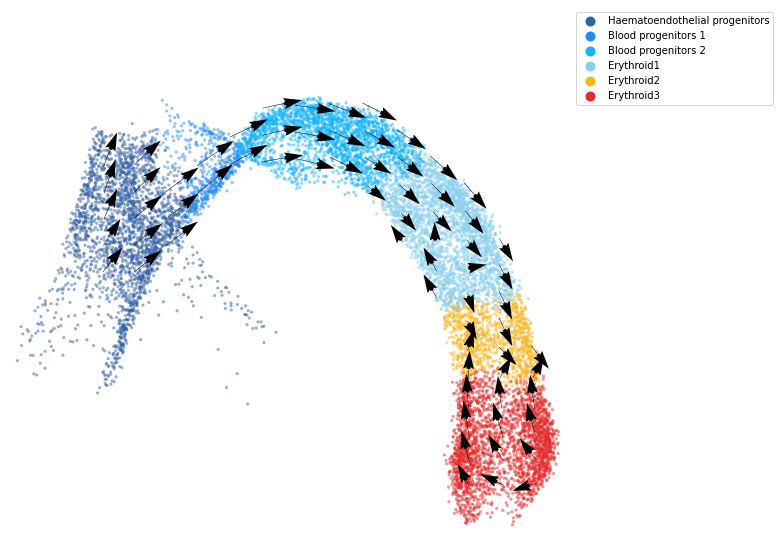

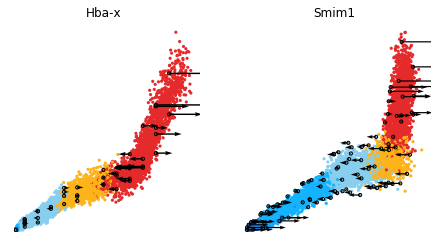






Model fullvb using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:36) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'fullvb_velocity_umap', embedded velocity vectors (adata.obsm)


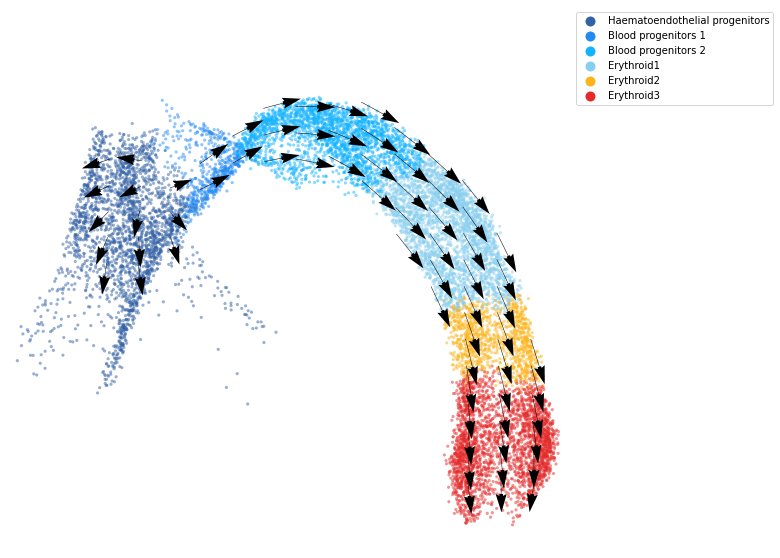

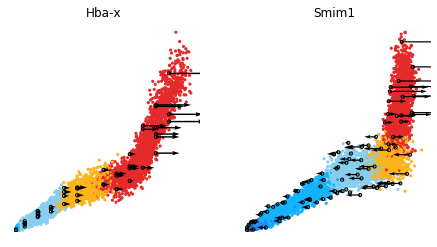






Model brode using all genes:
computing velocity graph (using 12/16 cores)


  0%|          | 0/12329 [00:00<?, ?cells/s]

    finished (0:01:35) --> added 
    'brode_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'brode_velocity_umap', embedded velocity vectors (adata.obsm)


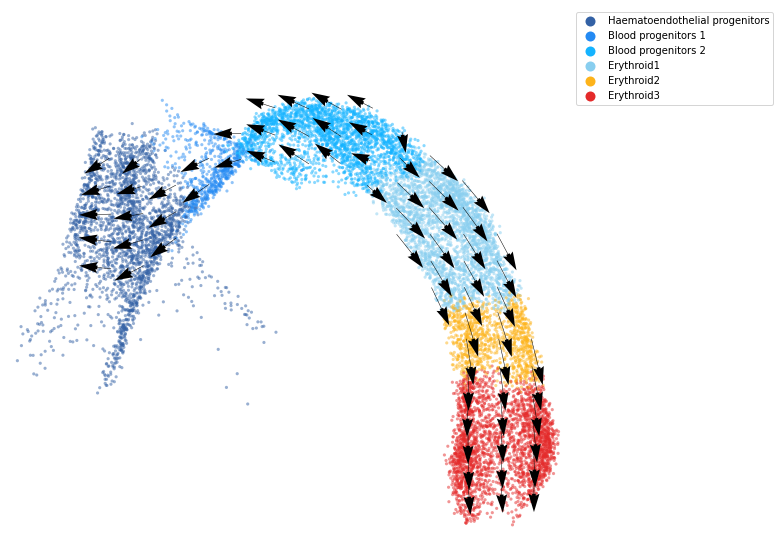

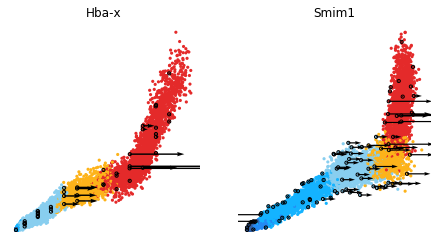

In [24]:

figure_path_base = f"figures/{dataset}_murk"
data_path_base = f"data/{dataset}_murk"

adata_murk.var['velocity_genes']=True


basis = "umap"
gene_list = ['Hba-x','Smim1']

for key in ['vae', 'fullvb', 'brode']:
    print("\n\n\n\n")
    print(f"Model {key} using all genes:")
    ## Convert ADATA to Dataframe. 
    # Note VeloVADE does not have the feature to calculate du/dt, we set it to 0.
    scv.tl.velocity_graph(adata_murk, vkey=f'{key}_velocity', n_jobs=12)
    scv.tl.velocity_embedding(adata_murk, vkey=f'{key}_velocity', basis=basis)
    adata_murk.write_h5ad(data_path_base+f"/{dataset}_murk_out.h5ad")

    df = adata_to_df(adata_murk, \
        us_para=['Mu', 'Ms'], us_pred_para=[f'{key}_velocity_u', f'{key}_velocity'], \
        cell_type_para='clusters', embed_para=f'X_{basis}', \
        embed_pred_para=f'{key}_velocity_{basis}', \
        dt = 0.5)

    # plot cell velocity
    fig, ax = plt.subplots(figsize=(10,10))
    cd.cdplt.scatter_cell(ax,
                    df,
                    colors=cd.cdplt.colormap.colormap_erythroid,
                    alpha=0.5,
                    s=10,
                    velocity=True,
                    legend='on',
                    min_mass=200,
                    arrow_grid=(20,40),
                    custom_xlim=[-5,11],
                    custom_ylim=[4,18])

    ax.axis('off')
    plt.savefig(figure_path_base+f"/cell_velocity_murk_genes_{key}_{basis}.pdf")

    plt.show()

    ncols=5
    height=math.ceil(len(gene_list)/5)*4
    fig = plt.figure(figsize=(20, height))

    for i in range(len(gene_list)):
        ax = fig.add_subplot(math.ceil(len(gene_list)/ncols), ncols, i+1)
        cd.cdplt.scatter_gene(
            ax=ax,
            x='splice',
            y='unsplice',
            cellDancer_df=df,
            custom_xlim=None,
            custom_ylim=None,
            colors=cd.cdplt.colormap.colormap_erythroid,
            alpha=1,
            s = 10,
            velocity=True,
            gene=gene_list[i])

        ax.set_title(gene_list[i])
        ax.axis('off')
    plt.savefig(figure_path_base+f"/gene_velocity_murk_genes_{key}.pdf")
    plt.show()